# RNNs in TF
* turns out it's pretty simple to code with a few simple swaps

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
                 
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Dense, Input, SimpleRNN, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy



2022-08-14 11:44:31.886217: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-14 11:44:31.886253: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/rdivine/miniconda3/envs/tf2/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
# all from tf_ann & tf_cnn notebook

articles = []
labels = []

with open('input/bbc_text_cls.csv') as f:
    running_art = ''
    for l in f.readlines()[1:]:
        if '",' not in l or '", ' in l:
            running_art += f'{l.strip()} '
        else:
            last_line = l.split('",')
            assert len(last_line) == 2
            articles.append(running_art + last_line[0].strip())
            labels.append(last_line[1].strip())
            running_art = ''

label2int = {}
count = 0
for l in labels:
    if l not in label2int:
        label2int[l] = count
        count += 1

int_labels = [label2int[l] for l in labels]
df = pd.DataFrame(list(zip(articles, int_labels)), columns=['text', 'labels'])
df.head()


,text,labels
0,"""Ad sales boost Time Warner profit Quarterly ...",0
1,"""Dollar gains on Greenspan speech The dollar ...",0
2,"""Yukos unit buyer faces loan claim The owners...",0
3,"""High fuel prices hit BA's profits British Ai...",0
4,"""Pernod takeover talk lifts Domecq Shares in ...",0


In [6]:
df_train, df_test = train_test_split(df, test_size=0.3)

tokenizer = Tokenizer(
    num_words = 2000
)
tokenizer.fit_on_texts(df_train['text'])
sequences_train = tokenizer.texts_to_sequences(df_train['text'])
sequences_test = tokenizer.texts_to_sequences(df_test['text'])

pad_train = pad_sequences(sequences_train)

# T is the sequence len. could also do pad_train.shape[1]
T = len(pad_train[0]) 

pad_test = pad_sequences(sequences_test, maxlen=T)

df_train['text_vec'] = pad_train.tolist()
df_test['text_vec'] = pad_test.tolist()

df_train = df_train[['text_vec', 'labels']]
df_test = df_test[['text_vec', 'labels']]
df_train.head()

,text_vec,labels
695,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
1602,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3
1261,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3
1051,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2
1635,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3


In [7]:
# V = the length of the word to int vector, aka vocab size
V = len(tokenizer.word_index)

# T is the sequence len. could also do pad_train.shape[1]
T = len(pad_train[0]) 

# pick D embedding size hyperparameter, could be changed
D = 50

K = len(label2int)

V, T, D, K

(27797, 3247, 50, 5)

In [16]:
# build model

M = 32 # is M just a hyperparameter? I think so.

i = Input(shape=(T,))
x = Embedding(V+1, D)(i)
x = SimpleRNN(M)(x)
x = Dense(K)(x)

model = Model(i, x)
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 3489)]            0         
                                                                 
 embedding_1 (Embedding)     (None, 3489, 50)          1384850   
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 32)                2656      
                                                                 
 dense_1 (Dense)             (None, 5)                 165       
                                                                 
Total params: 1,387,671
Trainable params: 1,387,671
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

r = model.fit(
    df_train['text_vec'].tolist(),
    df_train['labels'].tolist(),
    epochs=10,
    validation_data = (
        df_test['text_vec'].tolist(),
        df_test['labels'].tolist()
    )
)


Epoch 1/10
48/48 [==============================] - 122s 2s/step - loss: 1.6031 - accuracy: 0.2510 - val_loss: 1.7454 - val_accuracy: 0.1687
Epoch 2/10
48/48 [==============================] - 95s 2s/step - loss: 1.4582 - accuracy: 0.4967 - val_loss: 1.5618 - val_accuracy: 0.3003
Epoch 3/10
48/48 [==============================] - 115s 2s/step - loss: 1.1239 - accuracy: 0.8061 - val_loss: 1.3602 - val_accuracy: 0.4582
Epoch 4/10
48/48 [==============================] - 103s 2s/step - loss: 0.7094 - accuracy: 0.9422 - val_loss: 1.2389 - val_accuracy: 0.5155
Epoch 5/10
48/48 [==============================] - 106s 2s/step - loss: 0.3796 - accuracy: 0.9894 - val_loss: 1.3115 - val_accuracy: 0.4752
Epoch 6/10
48/48 [==============================] - 108s 2s/step - loss: 0.2026 - accuracy: 1.0000 - val_loss: 1.1906 - val_accuracy: 0.5232
Epoch 7/10
48/48 [==============================] - 97s 2s/step - loss: 0.1137 - accuracy: 1.0000 - val_loss: 1.2323 - val_accuracy: 0.5108
Epoch 8/10
48/4

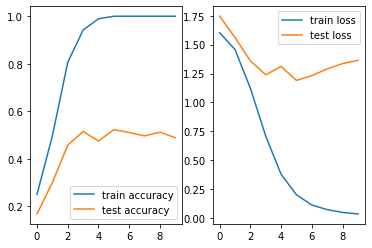

In [18]:
plt.subplot(1,2,1)
plt.plot(r.history['accuracy'], label='train accuracy')
plt.plot(r.history['val_accuracy'], label='test accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend()

plt.show()

In [10]:
### uh, wtf? why did test stay so bad? so dang overfit.
### regardless, let's try an LSTM approach

from tensorflow.keras.layers import LSTM, GlobalMaxPooling1D

M = 64
D = 32

i = Input(shape=(T,))
x = Embedding(V+1, D)(i)
x = LSTM(M, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(K)(x)

model = Model(i, x)
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3247)]            0         
                                                                 
 embedding_1 (Embedding)     (None, 3247, 32)          889536    
                                                                 
 lstm_1 (LSTM)               (None, 3247, 64)          24832     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 914,693
Trainable params: 914,693
Non-trainable params: 0
_____________________________________________________

In [11]:
model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

r = model.fit(
    df_train['text_vec'].tolist(),
    df_train['labels'].tolist(),
    epochs=20,
    validation_data = (
        df_test['text_vec'].tolist(),
        df_test['labels'].tolist()
    )
)


Epoch 1/20
48/48 [==============================] - 60s 1s/step - loss: 1.5983 - accuracy: 0.2324 - val_loss: 1.5788 - val_accuracy: 0.4102
Epoch 2/20
48/48 [==============================] - 55s 1s/step - loss: 1.5260 - accuracy: 0.4216 - val_loss: 2.0759 - val_accuracy: 0.2368
Epoch 3/20
48/48 [==============================] - 55s 1s/step - loss: 1.3778 - accuracy: 0.4748 - val_loss: 1.0757 - val_accuracy: 0.5418
Epoch 4/20
48/48 [==============================] - 55s 1s/step - loss: 0.8600 - accuracy: 0.7125 - val_loss: 0.6891 - val_accuracy: 0.8406
Epoch 5/20
48/48 [==============================] - 54s 1s/step - loss: 0.5088 - accuracy: 0.8785 - val_loss: 0.4411 - val_accuracy: 0.9381
Epoch 6/20
48/48 [==============================] - 55s 1s/step - loss: 0.3127 - accuracy: 0.9502 - val_loss: 0.2888 - val_accuracy: 0.9412
Epoch 7/20
48/48 [==============================] - 54s 1s/step - loss: 0.1760 - accuracy: 0.9562 - val_loss: 0.3077 - val_accuracy: 0.9040
Epoch 8/20
48/48 [==

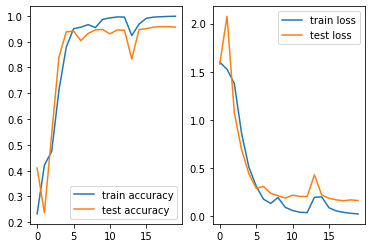

In [12]:
plt.subplot(1,2,1)
plt.plot(r.history['accuracy'], label='train accuracy')
plt.plot(r.history['val_accuracy'], label='test accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend()

plt.show()

In [25]:
pr_train = model.predict(df_train['text_vec'].tolist())
pr_test = model.predict(df_test['text_vec'].tolist())

21/21 [==============================] - 7s 317ms/step


In [29]:
from sklearn.metrics import roc_auc_score, roc_curve

print(f'AUC for train: {roc_auc_score(df_train["labels"], pr_train, multi_class="ovo")}')
print(f'AUC for train: {roc_auc_score(df_test["labels"], pr_test, multi_class="ovo")}')

ValueError: Target scores need to be probabilities for multiclass roc_auc, i.e. they should sum up to 1.0 over classes

In [30]:
dir(model)

['_SCALAR_UPRANKING_ON',
 '_TF_MODULE_IGNORED_PROPERTIES',
 '__annotations__',
 '__call__',
 '__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_activity_regularizer',
 '_add_trackable',
 '_add_trackable_child',
 '_add_variable_with_custom_getter',
 '_assert_compile_was_called',
 '_assert_weights_created',
 '_auto_track_sub_layers',
 '_autocast',
 '_autographed_call',
 '_base_model_initialized',
 '_build_input_shape',
 '_call_accepts_kwargs',
 '_call_arg_was_passed',
 '_call_fn_arg_defaults',
 '_call_fn_arg_positions',
 '_call_fn_args',
 '_call_full_argspec',
 '_callable_losses',
 '_captured_weight_regularize